## Package Imports

In [14]:
import torch 
from torch import optim
from torch.optim import Optimizer
from torch.nn import Linear, CrossEntropyLoss
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

from torchvision import transforms
from torchvision.models import ResNet
from torchvision.models import resnet34
from torchvision.datasets import ImageFolder

from numpy import log10, floor

from PIL import Image

## Load the images data

In [15]:
def pad_to_square(stock):
    x, y = stock.size
    d = max(x, y)
    padded = Image.new(mode='RGB', size=(d, d), color=(255, 255, 255))
    padded.paste(stock, ((d - x) // 2, (d - y) // 2))
    return padded

image_refactor = transforms.Compose([
    transforms.Lambda(pad_to_square),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

real_test_set = ImageFolder(root='./data/real_test', transform=image_refactor)
real_train_set = ImageFolder(root='./data/real_train', transform=image_refactor)
sketch_test_set = ImageFolder(root='./data/sketch_test', transform=image_refactor)
sketch_train_set = ImageFolder(root='./data/sketch_train', transform=image_refactor)

real_test_loader = DataLoader(real_test_set, batch_size=64, shuffle=True)
real_train_loader = DataLoader(real_train_set, batch_size=64, shuffle=True)
sketch_test_loader = DataLoader(sketch_test_set, batch_size=64, shuffle=True)
sketch_train_loader = DataLoader(sketch_train_set, batch_size=64, shuffle=True)


## Define the `train()` function

In [16]:
def train(
    model: ResNet, 
    src_loader: DataLoader, 
    optimizer: Optimizer,
    loss_fn = CrossEntropyLoss(),
    epochs: int = 1,
    early_stop_delta: float = -1,
    checkpoint_dir_prefix: str = None,
):
    model.train()
    train_losses = []
    train_accs = []
    epochs_digits = int(floor(log10(epochs)) + 1)

    # iterate over number of epochs / training iterations
    for e in range(epochs):
        r_loss = 0.0
        train_loss = 0.0
        correct_matches = 0
        y_dim = 0

        # iterate over batches
        for i, (X, y) in enumerate(src_loader):
            # reset optimizer
            optimizer.zero_grad()

            # perform the forward pass
            _y_probs = model.forward(X)

            # calculate the loss
            loss = loss_fn(_y_probs, y)

            with torch.no_grad():
                r_loss += loss.item()
                train_loss += loss.item()
                _y = _y_probs.softmax(dim=1).argmax(dim=1)
                correct_matches += (y == _y).sum().item()
                y_dim += y.size(0)

            # perform the backward pass
            loss.backward()

            # perform a gradient optimization
            optimizer.step()

        if checkpoint_dir_prefix is not None:
            torch.save(model.state_dict(), "{}/{:0{}d}.pth".format(checkpoint_dir_prefix, e, epochs_digits))

        train_accs.append(correct_matches / y_dim)

        # early stopping: will calculate the output for one extra iteration to document the performance of the final training cycle
        if (len(train_losses) > 0) and ((train_losses[-1] - train_loss) < (train_losses[-1] * early_stop_delta)):
            train_losses.append(train_loss)

            with torch.no_grad():
                train_losses.append(0.0)
                correct_matches = 0
                y_dim = 0

                for i, (X, y) in enumerate(src_loader):
                    _y_probs = model.forward(X)
                    train_losses[-1] += loss_fn(_y_probs, y).item()
                    _y = _y_probs.softmax(dim=1).argmax(dim=1)
                    correct_matches += (y == _y).sum().item()
                    y_dim += y.size(0)

                train_accs.append(correct_matches / y_dim)
            
            return (model, train_losses[1:], train_accs[1:])

        train_losses.append(train_loss)

    # calculating the output for one extra iteration to document the performance of the final training cycle
    with torch.no_grad():
        train_losses.append(0.0)
        correct_matches = 0
        y_dim = 0

        for i, (X, y) in enumerate(src_loader):
            _y_probs = model.forward(X)
            train_losses[-1] += loss_fn(_y_probs, y).item()
            _y = _y_probs.softmax(dim=1).argmax(dim=1)
            correct_matches += (y == _y).sum().item()
            y_dim += y.size(0)

        train_accs.append(correct_matches / y_dim)
    
    return (model, train_losses[1:], train_accs[1:])

## Define the `test()` function

In [17]:
def test(
    model: ResNet, 
    src_loader: DataLoader, 
    loss_fn = CrossEntropyLoss()
):
    model.eval()

    test_loss = 0.0
    test_acc = 0.0

    correct_matches = 0
    y_dim = 0

    for i, (X, y) in enumerate(src_loader):
        _y_probs = model.forward(X)
        test_loss += loss_fn(_y_probs, y).item()
        _y = _y_probs.softmax(dim=1).argmax(dim=1)
        correct_matches += (y == _y).sum().item()
        y_dim += y.size(0)

    test_acc = correct_matches / y_dim

    return (test_loss, test_acc)

## Define a function for training and validating

In [18]:
def train_and_validate(
    model: ResNet, 
    src_loader: DataLoader, 
    val_loader: DataLoader, 
    optimizer: Optimizer,
    loss_fn = CrossEntropyLoss(),
    epochs: int = 1,
    early_stop_margin: float = -1,
    checkpoint_dir_prefix: str = None,
):
    model.train()
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    # loss_deltas = []
    epochs_digits = int(floor(log10(epochs)) + 1)

    # training iterations
    for e in range(epochs):
        r_loss = 0.0
        train_losses.append(0.0)
        correct_matches = 0
        y_dim = 0

        # iterate over batches
        for i, (X, y) in enumerate(src_loader):
            optimizer.zero_grad()

            # forward pass
            _y_probs = model.forward(X)
            
            # loss
            loss = loss_fn(_y_probs, y)

            with torch.no_grad():
                r_loss += loss.item()
                train_losses[-1] += loss.item()
                _y = _y_probs.softmax(dim=1).argmax(dim=1)
                correct_matches += (y == _y).sum().item()
                y_dim += y.size(0)

            # backward pass
            loss.backward()
            optimizer.step()

        if checkpoint_dir_prefix is not None:
            torch.save(model.state_dict(), "{}/{:0{}d}.pth".format(checkpoint_dir_prefix, e, epochs_digits))

        train_accs.append(correct_matches / y_dim)

        # validation
        with torch.no_grad():
            val_losses.append(0.0)
            correct_matches = 0
            y_dim = 0

            for i, (X, y) in enumerate(val_loader):
                _y_probs = model.forward(X)
                val_losses[-1] += loss_fn(_y_probs, y).item()
                _y = _y_probs.softmax(dim=1).argmax(dim=1)
                correct_matches += (y == _y).sum().item()
                y_dim += y.size(0)

            val_accs.append(correct_matches / y_dim)

        # early stopping alternative (on loss delta percentile)
        # loss_delta = train_losses[-2] - train_losses[-1] if len(train_losses) > 1 else 0.0
        # if (len(loss_deltas) > 0) and (loss_delta < (loss_deltas[-1] * early_stop_margin)):

        # early stopping on loss delta
        # will calculate the output for one extra iteration to document the performance of the final training cycle
        if (len(train_losses) > 1) and ((train_losses[-2] - train_losses[-1]) < early_stop_margin):

            with torch.no_grad():
                train_losses.append(0.0)
                correct_matches = 0
                y_dim = 0

                for i, (X, y) in enumerate(src_loader):
                    _y_probs = model.forward(X)
                    train_losses[-1] += loss_fn(_y_probs, y).item()
                    _y = _y_probs.softmax(dim=1).argmax(dim=1)
                    correct_matches += (y == _y).sum().item()
                    y_dim += y.size(0)

                train_accs.append(correct_matches / y_dim)
            
            return {
                "model": model,
                "train-losses": train_losses[1:],
                "train-accs": train_accs[1:],
                "val-losses": val_losses,
                "val-accs": val_accs,
            }

        # loss_deltas.append(loss_delta)

    # calculating the output for one extra iteration to document the performance of the final training cycle
    with torch.no_grad():
        train_losses.append(0.0)
        correct_matches = 0
        y_dim = 0

        for i, (X, y) in enumerate(src_loader):
            _y_probs = model.forward(X)
            train_losses[-1] += loss_fn(_y_probs, y).item()
            _y = _y_probs.softmax(dim=1).argmax(dim=1)
            correct_matches += (y == _y).sum().item()
            y_dim += y.size(0)

        train_accs.append(correct_matches / y_dim)
    
    return {
        "model": model,
        "train-losses": train_losses[1:],
        "train-accs": train_accs[1:],
        "val-losses": val_losses,
        "val-accs": val_accs,
    }

## Train a model on sketch domain for sketch domain

In [19]:
r34_sketch = resnet34(pretrained=True)
r34_sketch.fc = Linear(in_features=r34_sketch.fc.in_features, out_features=10)

# model, train_losses, train_accuracies, test_losses, test_accuracies
r34_sketch_metrics = \
    train_and_validate(
        r34_sketch, 
        sketch_train_loader, 
        sketch_test_loader, 
        optimizer=optim.SGD(r34_sketch.parameters(), lr=0.005, momentum=0.9), 
        epochs=100, 
        early_stop_margin=0.1,
        checkpoint_dir_prefix="./checkpoints/sketch-r34"
    )

c:\Program Files\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Program Files\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Train a model on real domain for sketch domain

In [20]:
r34_real = resnet34(pretrained=True)
r34_real.fc = Linear(in_features=r34_real.fc.in_features, out_features=10)

# model, train_losses, train_accuracies, test_losses, test_accuracies
r34_real_metrics = \
    train_and_validate(
        r34_real, 
        real_train_loader, 
        sketch_test_loader, 
        optimizer=optim.SGD(r34_real.parameters(), lr=0.005, momentum=0.9), 
        epochs=100, 
        early_stop_margin=0.1,
        checkpoint_dir_prefix="./checkpoints/real-r34"
    )

## Model performance graphs

<Figure size 432x288 with 0 Axes>

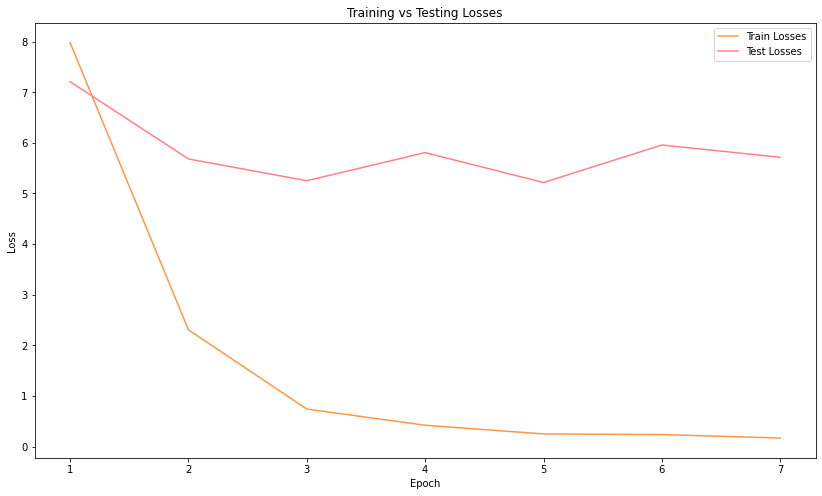

In [45]:
plt.clf()
epochs = range(1, len(r34_sketch_metrics["train-losses"]) + 1)

fig, canvas = plt.subplots(1, 1, figsize=(14, 8))

canvas.plot(epochs, r34_sketch_metrics["train-losses"], color=(255/255, 150/255, 69/255), label="Train Losses")
canvas.plot(epochs, r34_sketch_metrics["val-losses"], color=(255/255, 129/255, 131/255), label="Test Losses")
canvas.set_title("Training vs Testing Losses")
canvas.set_xlabel("Epoch")
canvas.set_ylabel("Loss")
canvas.set_xticks(epochs)
canvas.legend(loc="upper right")

plt.savefig("./fig/sketch-r34-losses.jpg")


<Figure size 432x288 with 0 Axes>

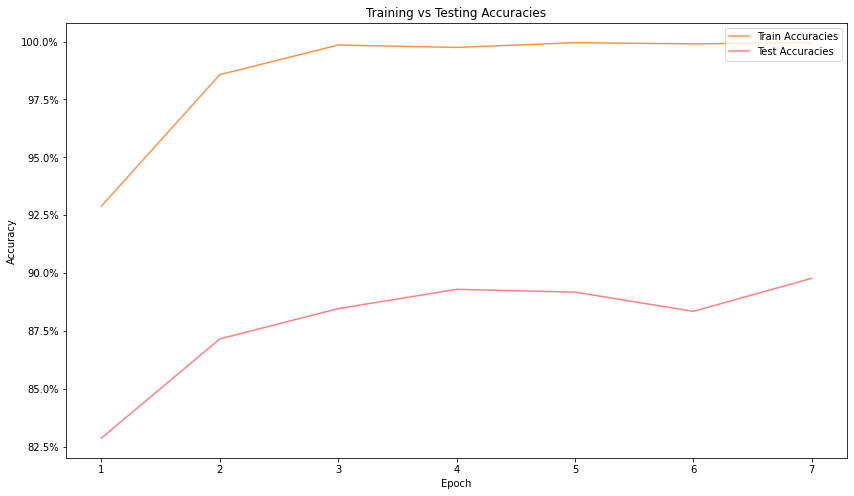

In [46]:
plt.clf()

fig, canvas = plt.subplots(1, 1, figsize=(14, 8))

canvas.plot(epochs, r34_sketch_metrics["train-accs"], color=(255/255, 150/255, 69/255), label="Train Accuracies")
canvas.plot(epochs, r34_sketch_metrics["val-accs"], color=(255/255, 129/255, 131/255), label="Test Accuracies")
canvas.set_title("Training vs Testing Accuracies")
canvas.set_xlabel("Epoch")
canvas.set_ylabel("Accuracy")

canvas.set_xticks(epochs)
canvas.yaxis.set_major_formatter(PercentFormatter(1.0))
canvas.legend(loc="upper right")

plt.savefig("./fig/sketch-r34-accs.jpg")


<Figure size 432x288 with 0 Axes>

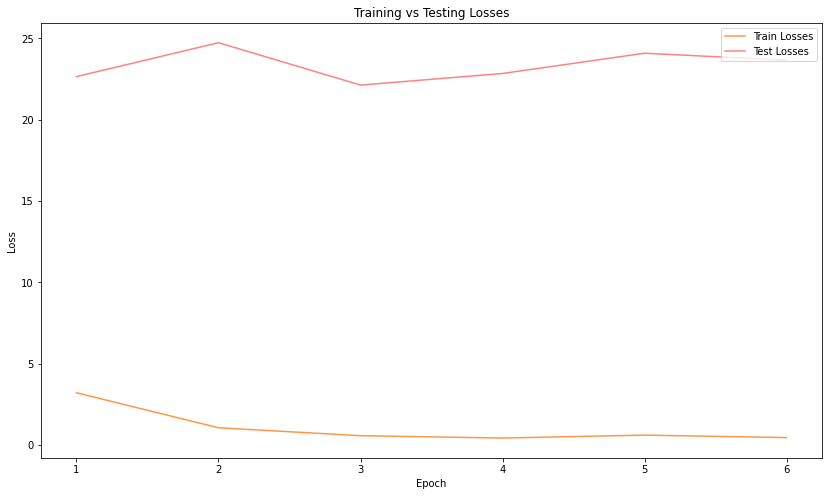

In [47]:
plt.clf()
epochs = range(1, len(r34_real_metrics["train-losses"]) + 1)

fig, canvas = plt.subplots(1, 1, figsize=(14, 8))

canvas.plot(epochs, r34_real_metrics["train-losses"], color=(255/255, 150/255, 69/255), label="Train Losses")
canvas.plot(epochs, r34_real_metrics["val-losses"], color=(255/255, 129/255, 131/255), label="Test Losses")
canvas.set_title("Training vs Testing Losses")
canvas.set_xlabel("Epoch")
canvas.set_ylabel("Loss")
canvas.set_xticks(epochs)
canvas.legend(loc="upper right")

plt.savefig("./fig/real-r34-losses.jpg")


<Figure size 432x288 with 0 Axes>

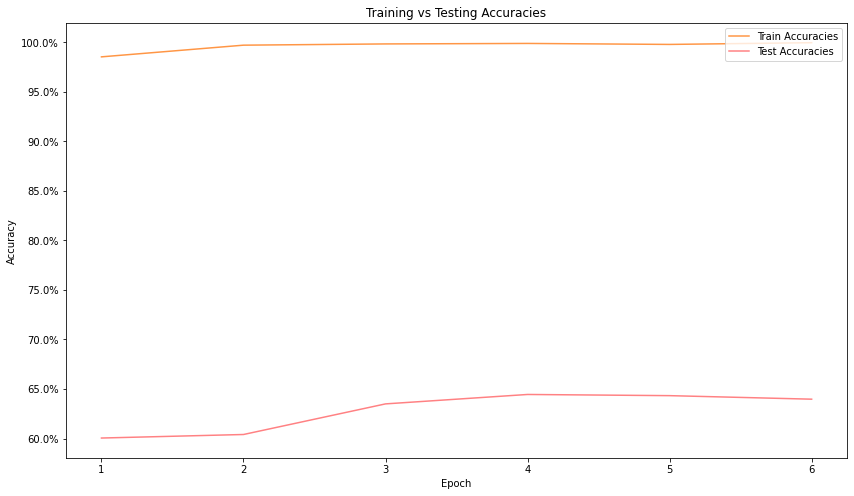

In [48]:
plt.clf()

fig, canvas = plt.subplots(1, 1, figsize=(14, 8))

canvas.plot(epochs, r34_real_metrics["train-accs"], color=(255/255, 150/255, 69/255), label="Train Accuracies")
canvas.plot(epochs, r34_real_metrics["val-accs"], color=(255/255, 129/255, 131/255), label="Test Accuracies")
canvas.set_title("Training vs Testing Accuracies")
canvas.set_xlabel("Epoch")
canvas.set_ylabel("Accuracy")

canvas.set_xticks(epochs)
canvas.yaxis.set_major_formatter(PercentFormatter(1.0))
canvas.legend(loc="upper right")

plt.savefig("./fig/real-r34-accs.jpg")


In [49]:
r34_sketch_metrics["val-losses"]

[7.208946228027344,
 5.682310730218887,
 5.25224506855011,
 5.807553723454475,
 5.216785028576851,
 5.957884721457958,
 5.714969232678413]

In [51]:
r34_sketch_metrics["val-accs"]

[0.8287752675386445,
 0.8715814506539834,
 0.8846611177170036,
 0.8929845422116528,
 0.89179548156956,
 0.8834720570749108,
 0.8977407847800237]

In [50]:
r34_real_metrics["val-losses"]

[22.645012617111206,
 24.728487253189087,
 22.122859120368958,
 22.83592665195465,
 24.08143126964569,
 23.65090835094452]

In [29]:
r34_real_metrics["val-accs"]

[0.6004756242568371,
 0.6040428061831153,
 0.6349583828775267,
 0.6444708680142688,
 0.643281807372176,
 0.6397146254458977]